# Face Mask Detector

**Author:** Samuele Da Mar

**Description:** Training an image classifier from scratch on with or without mask dataset.

**References:** 
1.   https://keras.io/examples/vision/image_classification_from_scratch/
2.   https://github.com/samacciu23/Build-A-Face-Mask-Detector-With-TensorFlow

**Dataset:** https://github.com/samacciu23/observations/tree/master/experiements/data

## Setup


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: the WITH or WITHOUT dataset

### Raw data download

First, let's download the ZIP archive of the raw data:


In [ ]:
!wget https://github.com/samacciu23/Face-Mask-Detection/raw/main/data.zip

--2021-12-06 17:59:20--  https://github.com/samacciu23/Face-Mask-Detection/raw/main/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/samacciu23/Face-Mask-Detection/main/data.zip [following]
--2021-12-06 17:59:21--  https://raw.githubusercontent.com/samacciu23/Face-Mask-Detection/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52807175 (50M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  50.36M   143MB/s    in 0.4s    

2021-12-06 17:59:22 (143 MB/s) - ‘data.zip’ saved [52807175/52807175]



In [ ]:
!unzip \data.zip
!rm \data.zip

Archive:  data.zip
   creating: data/with_mask/
  inflating: data/with_mask/0-with-mask.jpg  
  inflating: data/with_mask/100-with-mask.jpg  
  inflating: data/with_mask/101-with-mask.jpg  
  inflating: data/with_mask/103-with-mask.jpg  
  inflating: data/with_mask/104-with-mask.jpg  
  inflating: data/with_mask/105-with-mask.jpg  
  inflating: data/with_mask/106-with-mask.jpg  
  inflating: data/with_mask/107-with-mask.jpg  
  inflating: data/with_mask/108-with-mask.jpg  
  inflating: data/with_mask/109-with-mask.jpg  
  inflating: data/with_mask/10-with-mask.jpg  
  inflating: data/with_mask/110-with-mask.jpg  
  inflating: data/with_mask/111-with-mask.jpg  
  inflating: data/with_mask/112-with-mask.jpg  
  inflating: data/with_mask/113-with-mask.jpg  
  inflating: data/with_mask/114-with-mask.jpg  
  inflating: data/with_mask/115-with-mask.jpg  
  inflating: data/with_mask/116-with-mask.jpg  
  inflating: data/with_mask/117-with-mask.jpg  
  inflating: data/with_mask/118-with-mask.j

Now we have a `data` folder which contain two subfolders, `with_mask` and `without_mask`. Each
 subfolder contains image files for each category.


In [ ]:
!ls \data

with_mask  without_mask


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [ ]:
import os

num_skipped = 0
for folder_name in ("with_mask", "without_mask"):
    folder_path = os.path.join("data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## Generate a `Dataset`


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=50,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=50,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1376 files belonging to 2 classes.
Using 1101 files for training.
Found 1376 files belonging to 2 classes.
Using 275 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 0 is "with_mask"
 and label 1 is "without_mask".


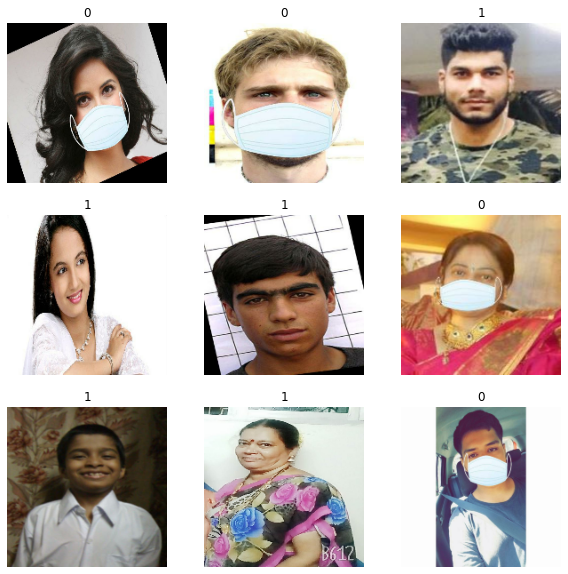

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(int(labels[i]))
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


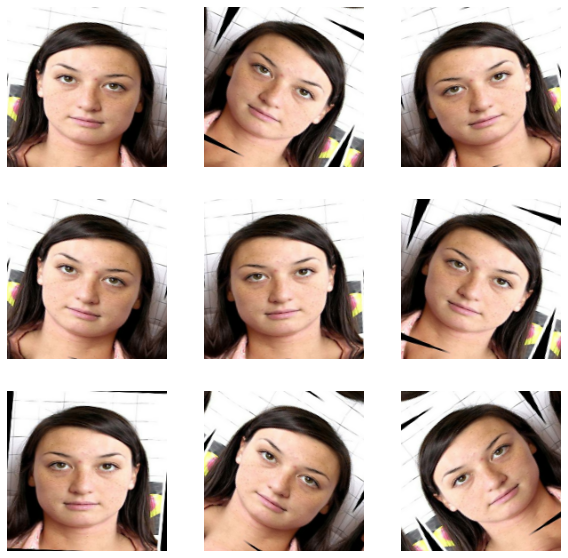

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Build the model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


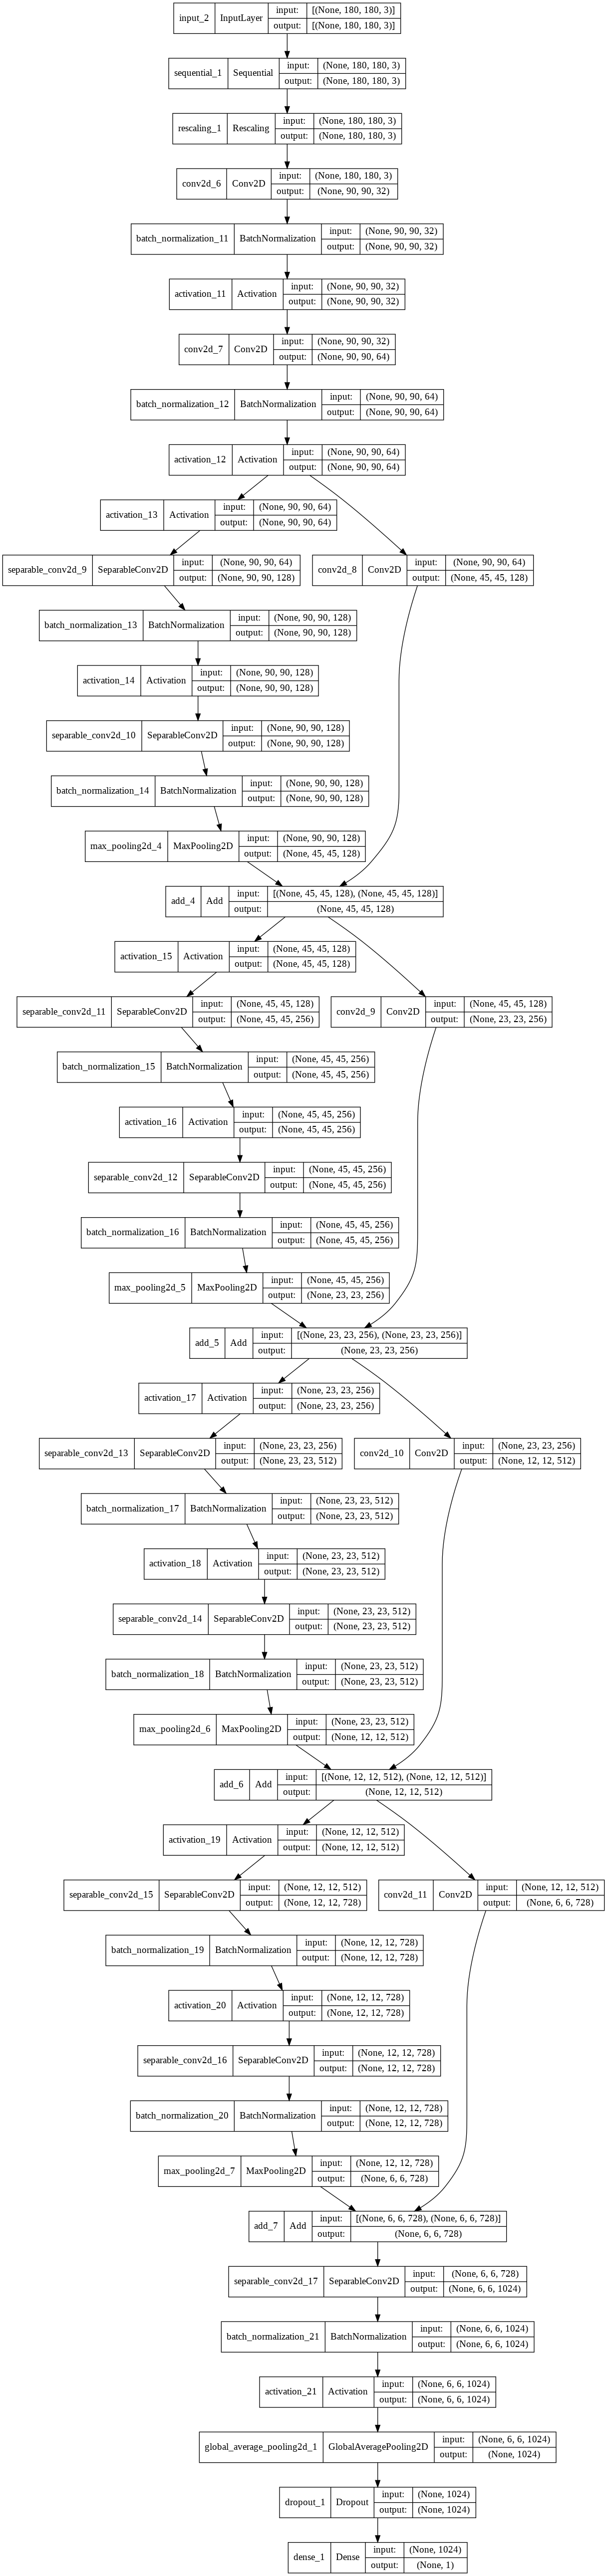

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 15  

# compile the model for training
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# train the model and save training history
history = model.fit(train_ds, 
                    epochs=epochs, 
                    validation_data=val_ds)
# save model weights to file
model.save_weights('model_weights.h5')

Epoch 1/15
35/35 [==============================] - 21s 507ms/step - loss: 0.0625 - accuracy: 0.9855 - val_loss: 0.7115 - val_accuracy: 0.5055
Epoch 2/15
35/35 [==============================] - 18s 490ms/step - loss: 0.0317 - accuracy: 0.9891 - val_loss: 0.7823 - val_accuracy: 0.5055
Epoch 3/15
35/35 [==============================] - 18s 493ms/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.8257 - val_accuracy: 0.5055
Epoch 4/15
35/35 [==============================] - 18s 496ms/step - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.9775 - val_accuracy: 0.5055
Epoch 5/15
35/35 [==============================] - 18s 495ms/step - loss: 0.0266 - accuracy: 0.9936 - val_loss: 1.1018 - val_accuracy: 0.5055
Epoch 6/15
35/35 [==============================] - 18s 496ms/step - loss: 0.0198 - accuracy: 0.9955 - val_loss: 1.4526 - val_accuracy: 0.5055
Epoch 7/15
35/35 [==============================] - 18s 496ms/step - loss: 0.0302 - accuracy: 0.9936 - val_loss: 2.0913 - val_accuracy: 0.5055

# Plot training behaviour

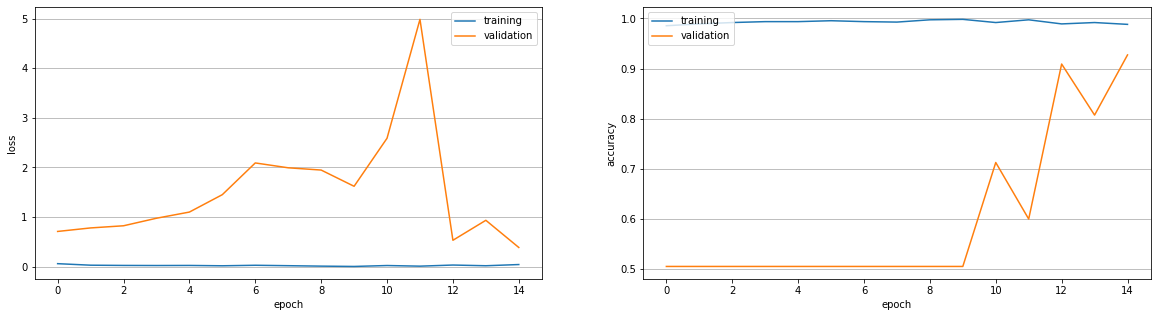

In [ ]:
# summarize history for loss and accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='upper right')
ax1.yaxis.grid()

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['training', 'validation'], loc='upper left')
ax2.yaxis.grid()

plt.show()

## Test the model's predictions

score =  2.1473891e-13


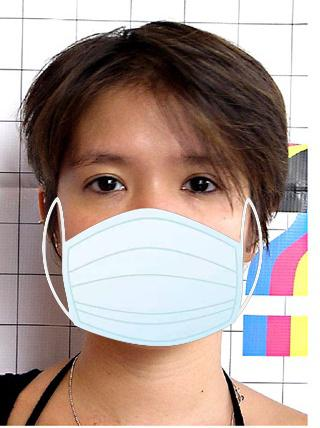

This image is 100.00 percent with-mask and 0.00 percent without.


In [ ]:
from IPython.display import Image, display

img_directory = "/content/data/with_mask/121-with-mask.jpg"
img = keras.preprocessing.image.load_img(img_directory, 
                                         target_size=image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print('score = ', score[0])
display(Image(img_directory, width= 150, height=150))
print(
    "This image is %.2f percent with-mask and %.2f percent without."
    % (100 * (1 - score[0]), 100 * score[0])
)
